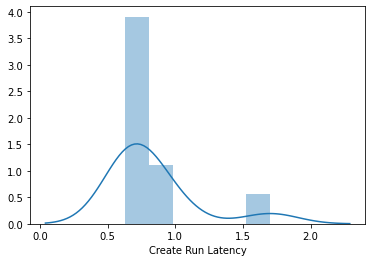

In [2]:
import random
import kfp
import kfp_server_api
import os
import string
import time
from google.cloud import storage
from kfp.components import create_component_from_func
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# CHANGE necessary paramters here
# host is your KFP endpoint
host = 'http://127.0.0.1:3000'
# Use the pipeline you prefer
pipeline_file_url = 'https://storage.googleapis.com/jingzhangjz-project-pipelines/benchmarks/taxi.yaml'
# number of times you want to run the pipeline
num_runs = 10


def random_suffix() -> string:
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))


if __name__ == '__main__':
    client = kfp.Client(host)
    
    api_url = kfp_server_api.models.ApiUrl(pipeline_file_url)
    api_pipeline = kfp_server_api.models.ApiPipeline(
        name='pipeline-' + random_suffix(),
        url=api_url)
    pipeline = client.pipelines.create_pipeline(body=api_pipeline)
    default_version_id = pipeline.default_version.id

    experiment_name = 'experiment-' + random_suffix()
    experiment = client.experiments.create_experiment(body={'name' : experiment_name})
    experiment_id = experiment.id
    
    # Measure create run latency
    create_run_latencies = []
    for i in range(num_runs):
        resource_references = []
        key = kfp_server_api.models.ApiResourceKey(id=experiment_id, type=kfp_server_api.models.ApiResourceType.EXPERIMENT)
        reference = kfp_server_api.models.ApiResourceReference(key=key, relationship=kfp_server_api.models.ApiRelationship.OWNER)
        resource_references.append(reference)
        key = kfp_server_api.models.ApiResourceKey(id=default_version_id, type=kfp_server_api.models.ApiResourceType.PIPELINE_VERSION)
        reference = kfp_server_api.models.ApiResourceReference(key=key, relationship=kfp_server_api.models.ApiRelationship.CREATOR)
        resource_references.append(reference)

        start = time.perf_counter()
        run_name = 'run-' + random_suffix()
        run = client.runs.create_run(body={'name':run_name, 'resource_references': resource_references})  
        dur = time.perf_counter() - start
        create_run_latencies.append(dur)      

    # Plot
    label_create_run_latencies = pd.Series(create_run_latencies, name='Create Run Latency')
    sns.distplot(a=label_create_run_latencies)